# Branch Classifier

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from datetime import datetime
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tifffile as tf
import torch

sys.path.append("../")
from data_prep import collect, load, draw
from solvers import branch_classifier
import models
date = datetime.now().strftime("%m-%d-%y")
dtype = torch.float32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Collect branch classifier training data
Training data consists of volumetric image patches chosen randomly from the neuron node coordinates given\
in the SWC file with an added small random translation. Image patches are labeled 1 if they are centered on\
 a branch point and 0 otherwise.

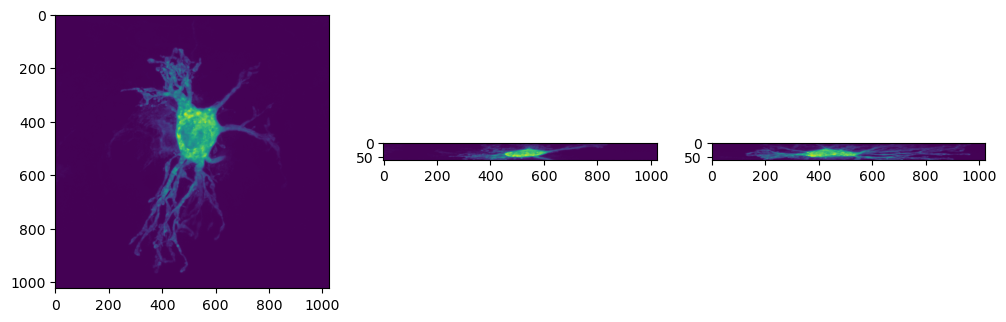

In [44]:
img_file = "/home/brysongray/bmap/gold166_tifs/09-2902-04R-01C-60x_merge_c1.tif"

img = tf.imread(img_file)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[1].imshow(img.max(1))
ax[2].imshow(img.max(2))


In [45]:
# file = "/Users/brysongray/Downloads/gold166/p_checked6_fruitfly_larvae_gmu/done_1_CL-I_X_OREGON_R_ddaD_membrane-GFP/1_CL-I_X_OREGON_R_ddaD_membrane-GFP.tif.v3dpbd.ano_stamp_2015_06_16_12_16.swc"
file = "/home/brysongray/Downloads/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc"

# load and parse the SWC file data
swc_list = load.swc(file)
sections, section_graph, branches, terminals, scale = load.parse_swc_list(swc_list, adjust=False)

loading file: /home/brysongray/Downloads/gold166/e_checked6_chick_uw/DONE_09-2902-04R-01C-60x_merge_c1/09-2902-04R-01C-60x_merge_c1.v3dpbd.swc


In [46]:
segments = []
for section in sections.values():
    segments.append(section)
segments = torch.concatenate(segments)

# shape = torch.ceil(torch.amax(segments, dim=(0,1)))
# shape = shape.to(torch.int)
# shape = shape + torch.tensor([10, 10, 10])  # type: ignore
# shape = tuple(shape.tolist())

density = draw.draw_neuron_density(segments, img.shape, width=3)
mask = draw.draw_neuron_mask(density, threshold=5.0)

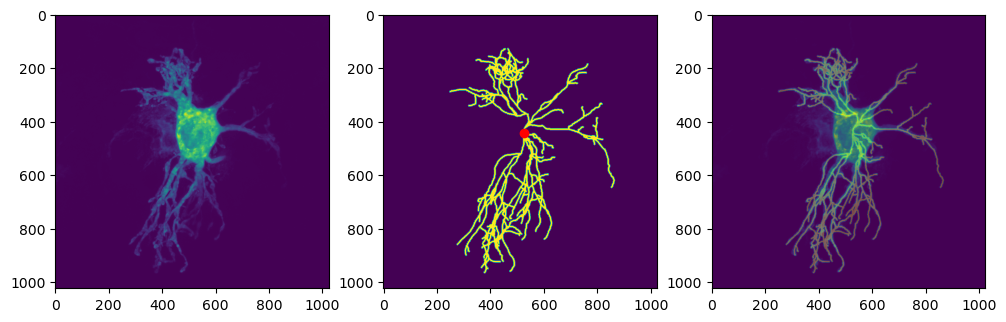

In [47]:
# img_ = img / 255.0
# # comp = np.stack((np.zeros(img.shape), np.array(mask[0]), img_), axis=-1)
# comp = np.stack((np.zeros(img.shape), np.array(mask[0]), img_), axis=-1)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[1].imshow(mask[0].amax(0))
ax[1].scatter(y=sections[1][0,0,1],x=sections[1][0,0,2], c='r')
ax[2].imshow(img.max(0))
ax[2].imshow(mask[0].amax(0), alpha=0.3)


In [57]:
import nibabel as nib

# save the mask as a NIfTI file
nifti_img = nib.Nifti1Image(mask[0].numpy(), affine=np.eye(4))
nib.save(nifti_img, 'mask.nii')

# save the img as a NIfTI file
nifti_img = nib.Nifti1Image(img, affine=np.eye(4))
nib.save(nifti_img, 'img.nii')

Floodfill from seed point

In [57]:
# flood fill algorithm for 3d volume
def flood_fill(volume, seed_point, new_value, tolerance=0):
    # Get the dimensions of the volume
    z_dim, y_dim, x_dim = volume.shape

    # Create a copy of the volume to avoid modifying the original
    filled_volume = np.copy(volume).astype(np.float32)

    # Get the value at the seed point
    seed_value = filled_volume[*seed_point]

    # Create a stack for the flood fill algorithm
    stack = [seed_point]

    while stack:
        z, y, x = stack.pop()

        if (0 <= z < z_dim and 0 <= y < y_dim and 0 <= x < x_dim and
                abs(filled_volume[z, y, x] - seed_value) <= tolerance):
            # Set the new value
            filled_volume[z, y, x] = new_value

            # Add neighboring points to the stack
            stack.append((z + 1, y, x))
            stack.append((z - 1, y, x))
            stack.append((z, y + 1, x))
            stack.append((z, y - 1, x))
            stack.append((z, y, x + 1))
            stack.append((z, y, x - 1))

    return filled_volume


In [61]:
# moravec detector
def moravec_detector(volume, window_size=3):
    # Get the dimensions of the volume
    z_dim, y_dim, x_dim = volume.shape

    # Create a copy of the volume to avoid modifying the original
    moravec_volume = np.zeros_like(volume).astype(np.float32)

    # Define the half window size
    half_window = window_size // 2

    # Iterate over each voxel in the volume
    for z in range(half_window, z_dim - half_window):
        for y in range(half_window, y_dim - half_window):
            for x in range(half_window, x_dim - half_window):
                # Extract the window
                window = volume[z - half_window:z + half_window + 1,
                                y - half_window:y + half_window + 1,
                                x - half_window:x + half_window + 1]

                # Compute the sum of squared differences
                ssd = np.sum((window - window.mean()) ** 2)

                # Store the result in the moravec volume
                moravec_volume[z, y, x] = ssd

    return moravec_volume


In [81]:
from scipy.ndimage import gaussian_filter

# harris detector
def harris_detector(volume, sigma=3.0, k=0.04):
    # Get the dimensions of the volume
    z_dim, y_dim, x_dim = volume.shape

    # Create a copy of the volume to avoid modifying the original
    harris_volume = np.zeros_like(volume).astype(np.float32)

    # Compute gradients in each direction
    Ix =  gaussian_filter(volume, sigma=[sigma]*3, order=(0,0,1))
    Iy =  gaussian_filter(volume, sigma=[sigma]*3, order=(0,1,0))
    Iz =  gaussian_filter(volume, sigma=[sigma]*3, order=(1,0,0))

    # Compute products of gradients
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Izz = Iz * Iz
    Ixy = Ix * Iy
    Ixz = Ix * Iz
    Iyz = Iy * Iz

    # Compute the Harris response for each voxel
    S = np.stack((Ixx, Ixy, Ixz, Ixy, Iyy, Iyz, Ixz, Iyz, Izz), axis=-1)
    S = S.reshape((S.shape[:-1]+(3,3)))

    # Compute the Harris response
    det_S = np.linalg.det(S)
    trace_S = np.trace(S, axis1=-2, axis2=-1)
    harris_volume = det_S - k * (trace_S ** 2)

    return harris_volume / harris_volume.min()

In [13]:
seed_point

[29, 443, 526]

In [14]:
img.shape

(62, 1024, 1024)

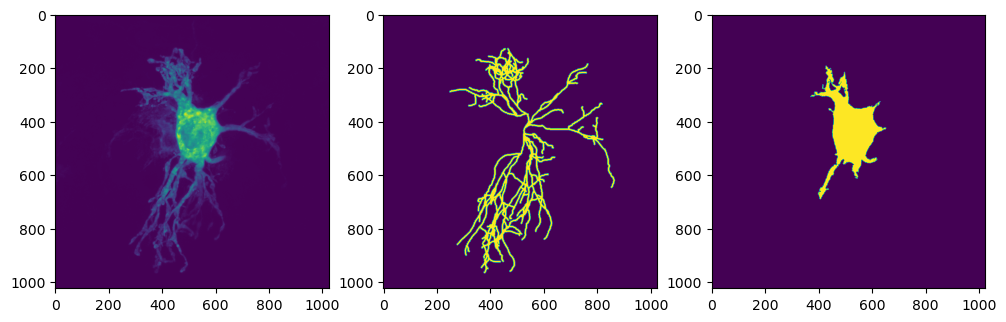

In [63]:
# flood fill img starting at seed point
# from skimage.segmentation import flood_fill

# seed_point = (int(sections[1][0,0,1]), int(sections[1][0,0,2]))
seed_point = sections[1][0,0,:3].to(torch.int).tolist()
filled_img = flood_fill(img, seed_point, 255, tolerance=80)
filled_img = np.where(filled_img == 255, filled_img, 0)
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img.max(0))
ax[1].imshow(mask[0].amax(0))
ax[2].imshow(filled_img.max(0))

In [93]:
test_img = np.zeros((35,35,35))
test_img[7:21,7:21,7:21] = np.ones((14,14,14))

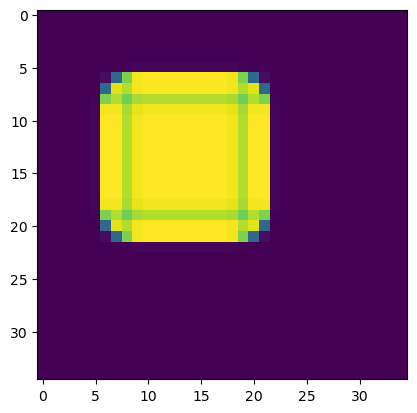

In [97]:
harris_img = harris_detector(test_img, sigma=1.0, k=0.04)

plt.imshow(harris_img.max(0))

### Get sample points from swc files

In [7]:
# Load SWC file data into python lists
labels_dir = "/home/brysongray/data/neuromorpho_sub1"
files = [f for x in os.walk(labels_dir) for f in glob(os.path.join(x[0], '*.swc'))]
swc_lists = []
for f in files:
    swc_lists.append(load.swc(f))

# Collect random sample points from SWC data
samples_per_file = 50
fnames = [f.split('/')[-1].split('.')[0] for f in files]
sample_points = collect.swc_random_points(samples_per_file, swc_lists, fnames, adjust=True)

loading file: /home/brysongray/data/neuromorpho_sub1/beining/CNG version/35dpi_ipsi_infra_06.CNG.swc
loading file: /home/brysongray/data/neuromorpho_sub1/campos/CNG version/Astro-1.CNG.swc
loading file: /home/brysongray/data/neuromorpho_sub1/allen cell types/CNG version/646805498_transformed.CNG.swc


### Save sample patches and labels from image files

In [12]:
# save sample patches from the images centered at the sample points
image_dir = "/home/brysongray/data/simulated_neurons/neuromorpho_sub1_with_artifacts"
out_dir = "classifier_data"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
name = "neuromorpho_test"

collect.collect_data(sample_points, image_dir, out_dir, name, date)

### View some example input images

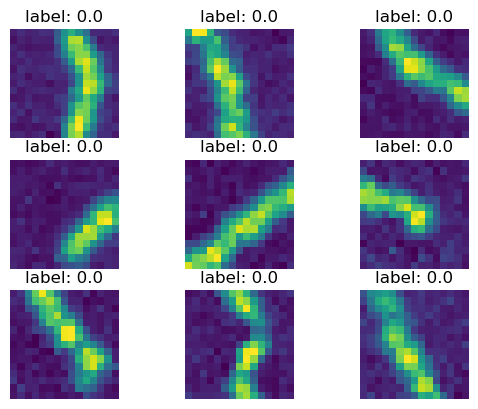

In [10]:
observations = os.listdir(os.path.join(out_dir, "observations"))
training_annotations = pd.read_csv(glob(os.path.join(out_dir, "*_labels.csv"))[0])
ids = np.random.choice(len(training_annotations), size=9)
sample = training_annotations.iloc[ids]

fig, ax = plt.subplots(3,3)
ax = ax.flatten()
for i in range(len(ax)):
    img = torch.load(os.path.join(out_dir,"observations", sample.iloc[i,0]), weights_only=True) # type: ignore
    ax[i].imshow(img[0].amax(0))
    ax[i].set_title(f"label: {sample.iloc[i,1].item()}")
    ax[i].set_axis_off()

    

## Train branch classifier

### Instantiate dataloader for training and test datasets
Dataloaders use a weighted random sampler to balance classes. Additionally, the training dataset\
 adds a random permutation and flip to the image patch at retrieval.

In [13]:
# set source data files paths
training_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_test_labels.csv"
test_labels_file = "classifier_data/branch_classifier_neuromorpho_test_02-07-25_training_labels.csv"
img_dir = "classifier_data/observations"

# instantiate training and test datasets
transform = branch_classifier.transform # random permutation and flip
training_data = branch_classifier.StateData(labels_file=training_labels_file,
                          img_dir=img_dir,
                          transform=transform)
test_data = branch_classifier.StateData(labels_file=test_labels_file,
                          img_dir=img_dir)

# instantiate dataloaders
training_dataloader = branch_classifier.init_dataloader(training_data)
test_dataloader = branch_classifier.init_dataloader(test_data)

## View balanced data

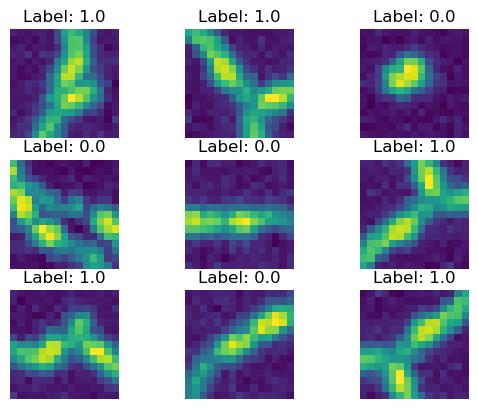

In [14]:
fig, axs = plt.subplots(3,3)
axs = axs.flatten()

X,y = next(iter(training_dataloader))
for i, ax in enumerate(axs):
    ax.imshow(X[i,0].amax(0))
    ax.set_title(f"Label: {y[i]}")
    ax.set_axis_off()

In [17]:
out_dir = "classifier_weights/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)

lr = 1e-3
epochs = 5
classifier = models.ResNet(models.ResidualBlock, [3, 4, 6, 3], num_classes=1)
classifier = classifier.to(device=DEVICE, dtype=dtype)

branch_classifier.train(training_dataloader, test_dataloader, out_dir, lr, epochs, classifier, state_dict=None)


Epoch 1
-------------------------------
Accuracy: 40.0, Loss: 0.405724  [   30/   30]
Test Error: 
 Accuracy: 50.0%, Avg loss: 24.919770 
           Precision: 0.500, Recall: 1.000
Epoch 2
-------------------------------
Accuracy: 76.66666666666667, Loss: 0.828855  [   30/   30]
Test Error: 
 Accuracy: 53.3%, Avg loss: 22.108765 
           Precision: 0.533, Recall: 1.000
Epoch 3
-------------------------------
Accuracy: 80.0, Loss: 0.543504  [   30/   30]
Test Error: 
 Accuracy: 51.7%, Avg loss: 23.350894 
           Precision: 0.517, Recall: 1.000
Epoch 4
-------------------------------
Accuracy: 70.0, Loss: 0.260397  [   30/   30]
Test Error: 
 Accuracy: 42.5%, Avg loss: 32.415985 
           Precision: 0.425, Recall: 1.000
Epoch 5
-------------------------------
Accuracy: 93.33333333333333, Loss: 0.181836  [   30/   30]
Test Error: 
 Accuracy: 48.3%, Avg loss: 26.552392 
           Precision: 0.483, Recall: 1.000
Done!
